In [1]:
    # import the necessary packages
import os
import torch

# DEVICE AGNOSTIC
#### set device to 'cpu' or 'cuda' (GPU) based on availability
#### for model training and testing
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# MODEL HYPERPARAMETER
LR = 0.001             # learning rate for the model

PATIENCE = 2           # early stopping during model training where training is stopped 
                       # when performance on a validation dataset does not improve 
                       # STOP The training when result is same for 2 consecutive epochs
        
IMAGE_SIZE = 512        # defines that the size of image is 256x256
CHANNELS = 3           # defines that image's color channel is 3
BATCH_SIZE = 16        # defines that 16 training examples are used in one iteration before 
                       # updating the weight and biases of network 
    
NUM_WORKERS = os.cpu_count()     # for parallel processing
EMBEDDING_DIM = 2      # defines size of the embedding space

EPOCHS = 10            # number of complete passes through the entire training dataset
                       # i.e. model is trained on the whole dataset 10 times

    
# DATASET PATH
# CELEBFACE_ROOT = "./data/img_align_celeba"
CELEBFACE_ROOT = "/kaggle/input/new-celeb-data/dataset_new/"



# OUTPUT DIRECTORY
# output_dir = "output"
# os.makedirs("output", exist_ok=True)

# # creates the training_progress directory inside the output directory
# training_progress_dir = os.path.join(output_dir, "training_progress")
# os.makedirs(training_progress_dir, exist_ok=True)


# # creates the model_weights directory inside the output directory
# # for storing autoencoder weights
# model_weights_dir = os.path.join(output_dir, "model_weights")
# os.makedirs(model_weights_dir, exist_ok=True)


In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
print(f" cuda count : {torch.cuda.device_count()}")
print(f" cuda name : {torch.cuda.get_device_name()}")

 cuda count : 1
 cuda name : Tesla P100-PCIE-16GB


In [4]:
import torch.nn.functional as F

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset

# Define transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Path to the CelebFace dataset directory

# Create dataset using ImageFolder
celebface_dataset = datasets.ImageFolder(
                                        root=CELEBFACE_ROOT,
                                        transform=transform
                                        )

# Split dataset into training and validation sets
train_size = int(0.8 * len(celebface_dataset))  # 80% for training
val_size = len(celebface_dataset) - train_size  # 20% for validation
# celeb_train_dataset, celeb_val_dataset = celebface_dataset[:train_size], celebface_dataset[train_size:val_size]
celeb_train_dataset, celeb_val_dataset = random_split(celebface_dataset, [train_size, val_size])

# Create DataLoader for training set
# batch_size = 64
### Train dataloader
celeb_train_dataloader = DataLoader(
                                    dataset=celeb_train_dataset, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS,
                                    pin_memory=True)

## Test dataloader
# Create DataLoader for validation set
celeb_val_dataloader = DataLoader(
                                    dataset=celeb_val_dataset, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS,
                                    pin_memory=True)

for images, labels in celeb_train_dataloader:
    # Do something with the training data
    print("Training data:")
    print(images.shape)  # Shape: (batch_size, channels, height, width)
    print(labels.shape)  # Shape: (batch_size,)
    break  # Break after first iteration for demonstration

for images, labels in celeb_val_dataloader:
    # Do something with the validation data
    print("Validation data:")
    print(images.shape)  # Shape: (batch_size, channels, height, width)
    print(labels.shape)  # Shape: (batch_size,)
    break  # Break after first iteration for demonstration


Training data:
torch.Size([16, 3, 512, 512])
torch.Size([16])
Validation data:
torch.Size([16, 3, 512, 512])
torch.Size([16])


---
# **Creating Noisy dataloader** 
---

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

class NoisyDataset(Dataset):
    def __init__(self, dataset, noise_std):
        self.dataset = dataset
        self.noise_std = noise_std

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]

        # Add noise to the image
        noisy_image = image + torch.randn_like(image) * self.noise_std
        noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure pixel values are in [0, 1] range

        return noisy_image, label

def create_noisy_dataloader(dataset, noise_std, batch_size=BATCH_SIZE):
    # Create noisy dataset
    noisy_dataset = NoisyDataset(dataset, noise_std)

    # Create noisy data loader
    loader = DataLoader(
                        dataset=noisy_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=NUM_WORKERS,
                        pin_memory=True
                       )
    return loader


---
# **Creaing Blurry Image dataset**
---

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import cv2

class BlurryDataset(Dataset):
    def __init__(self, dataset, blur_radius):
        self.dataset = dataset
        self.blur_radius = blur_radius

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]

        # Convert PIL image to numpy array
        image_np = transforms.ToPILImage()(image)
        image_np = np.array(image_np)

        # Apply blur using cv2.blur
        blurry_image = cv2.blur(image_np, (self.blur_radius, self.blur_radius))

        # Convert numpy array back to tensor
        blurry_image = transforms.ToTensor()(blurry_image)

        return blurry_image, label
    
def create_blurry_dataloader(dataset, blur_radius, batch_size=BATCH_SIZE):
    # Create noisy dataset
    blurry_dataset = BlurryDataset(dataset=dataset, blur_radius=blur_radius)
#     noisy_dataset = NoisyDataset(dataset, noise_std)

    # Create noisy data loader
    loader = DataLoader(
                        dataset=blurry_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=NUM_WORKERS,
                        pin_memory=True
                       )
    return loader



In [8]:
# blurry train dataloader
blur_radius = 20
celeb_blurry_train_dataloader = create_blurry_dataloader(dataset=celeb_train_dataset, blur_radius=blur_radius, batch_size=BATCH_SIZE)
celeb_blurry_val_dataloader = create_blurry_dataloader(dataset=celeb_val_dataset, blur_radius=blur_radius, batch_size=BATCH_SIZE)


# noisy train dataloader
noise_std = 0.6
celeb_noisy_train_dataloader = create_noisy_dataloader(celeb_train_dataset, noise_std, BATCH_SIZE)
celeb_noisy_val_dataloader = create_noisy_dataloader(celeb_val_dataset, noise_std, BATCH_SIZE)


In [9]:
print(f"""
Clean Image Dataset
---------------------------------------------------
Clean Train dataloader length : {len(celeb_train_dataloader)*BATCH_SIZE}
Clean Val dataloader length   : {len(celeb_val_dataloader)*BATCH_SIZE}
Total Clean images            : {len(celeb_train_dataloader)*BATCH_SIZE + len(celeb_val_dataloader)*BATCH_SIZE}


Noisy Image Dataset
---------------------------------------------------
Noisy Train dataloader length : {len(celeb_noisy_train_dataloader)*BATCH_SIZE}
Noisy Val dataloader length   : {len(celeb_noisy_val_dataloader)*BATCH_SIZE}
Total Noisy images            : {len(celeb_noisy_train_dataloader)*BATCH_SIZE + len(celeb_noisy_val_dataloader)*BATCH_SIZE}


Blurry Image Dataset
---------------------------------------------------
Noisy Train dataloader length : {len(celeb_blurry_train_dataloader)*BATCH_SIZE}
Noisy Val dataloader length   : {len(celeb_blurry_val_dataloader)*BATCH_SIZE}
Total Noisy images            : {len(celeb_blurry_train_dataloader)*BATCH_SIZE + len(celeb_blurry_val_dataloader)*BATCH_SIZE}

""")
!echo 'Total images in dataset : '$( ls -al /kaggle/input/new-celeb-data/dataset_new/dataset_new/*.jpg | wc -l )


Clean Image Dataset
---------------------------------------------------
Clean Train dataloader length : 8000
Clean Val dataloader length   : 2000
Total Clean images            : 10000


Noisy Image Dataset
---------------------------------------------------
Noisy Train dataloader length : 8000
Noisy Val dataloader length   : 2000
Total Noisy images            : 10000


Blurry Image Dataset
---------------------------------------------------
Noisy Train dataloader length : 8000
Noisy Val dataloader length   : 2000
Total Noisy images            : 10000


Total images in dataset : 10000


Clean Train Images:


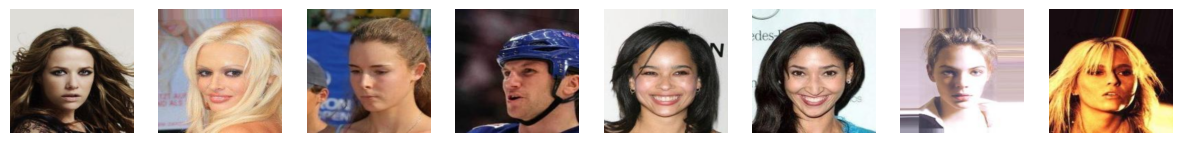

Blurry Train Images:


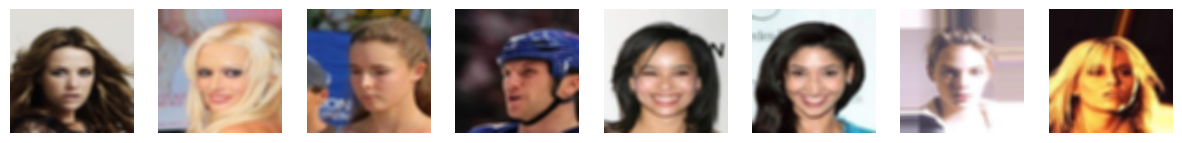

Noisy Train Images:


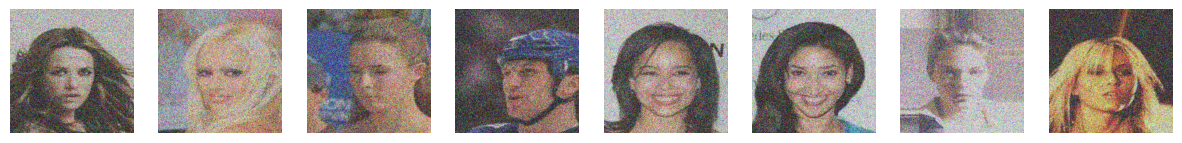




Clean Validation Images:


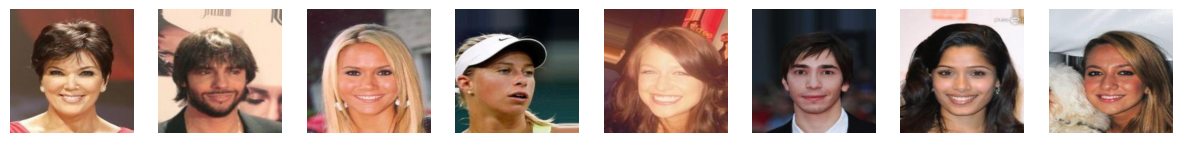

Blurry Validation Images:


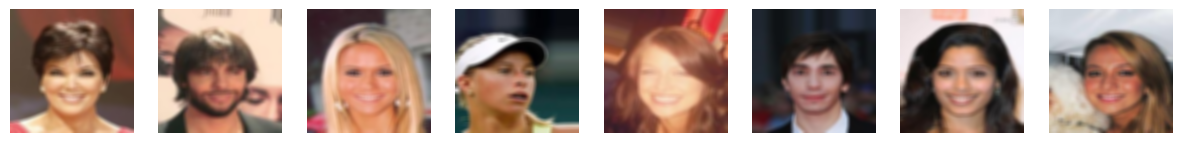

Noisy Validation Images:


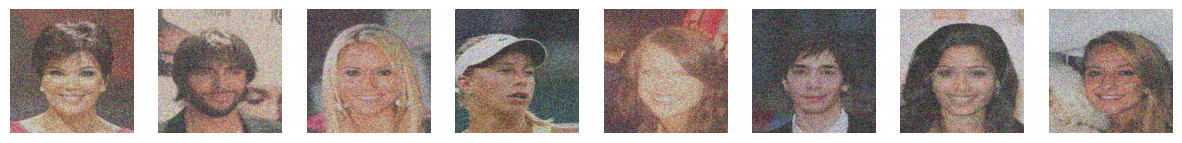

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataloader, num_images=8):
    # Get a batch of images
    for i, (images, _) in enumerate(dataloader):
        # Display images from the batch
        plt.figure(figsize=(15, 5))
        for j in range(num_images):
            plt.subplot(1, num_images, j + 1)
            image = images[j].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and permute dimensions
            plt.imshow(image)
            plt.axis('off')
        plt.show()
        break 
        
        
print("Clean Train Images:")
show_images(celeb_train_dataloader)

print("Blurry Train Images:")
show_images(celeb_blurry_train_dataloader)

print("Noisy Train Images:")
show_images(celeb_noisy_train_dataloader)





print("\n\n\nClean Validation Images:")
show_images(celeb_val_dataloader)

print("Blurry Validation Images:")
show_images(celeb_blurry_val_dataloader)

print("Noisy Validation Images:")
show_images(celeb_noisy_val_dataloader)

---
## Export the images of dataloader
---

In [12]:
# import os
# from torchvision import transforms
# from PIL import Image

# def export_images_from_dataloader(dataloader, folder_name):
#     # Create output directory if it doesn't exist
#     os.makedirs(folder_name, exist_ok=True)
    
#     # Iterate through the dataloader and export images
#     for i, (image, _) in enumerate(dataloader):
#         # Assuming image is in tensor format, convert it to PIL image
#         image_pil = transforms.ToPILImage()(image[0])  # Assuming batch size is 1
        
#         # Save the image to the output folder
#         image_pil.save(os.path.join(folder_name, f'image_{i}.jpg'))
#         print(f"{i}, ", end="")
    
#     print(f"Images exported successfully to '{folder_name}'.")

# # Example usage:
# export_images_from_dataloader(celeb_blurry_train_dataloader, './dataset/blurry_image_data/train')


# Display Image

This function displays the function form the dataloader provided in variable `dataloader`

In [14]:
import numpy as np 
import matplotlib.pyplot as plt
def display_images_from_dataloader(dataloader, title):
    # Fetch 30 images from the dataloader
    images = []
    for i, batch in enumerate(dataloader):
        images.extend(batch[0])
        if i == 2:  # Fetching 10 images from each batch, assuming batch size is 10
            break

    # Display the images
#     plt.suptitle(title, fontsize=16)
    fig, axes = plt.subplots(3, 10, figsize=(20, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.axis('off')
    fig.suptitle(title)
    plt.show()

In [42]:
# # Train dataloader
# #### Noisy Train dataloader
# display_images_from_dataloader(celeb_noisy_train_dataloader, "Celeb Noisy Train DataLoader")

# ##### Blurry Train Dataloader
# display_images_from_dataloader(celeb_blurry_train_dataloader, "Celeb Blurry Train DataLoader")

# ##### Clean Train dataloader
# display_images_from_dataloader(celeb_train_dataloader, "Celeb Celeb Train DataLoader")


In [43]:
# # Test dataloader
# ##### Noisy Test Dataloader
# display_images_from_dataloader(celeb_noisy_val_dataloader, "Celeb Noisy Validation DataLoader")

# ##### Blurry Test Dataloader
# display_images_from_dataloader(celeb_blurry_val_dataloader, "Celeb Blurry Validation DataLoader")

# ##### Clean Test Dataloader
# display_images_from_dataloader(celeb_val_dataloader, "Celeb Clean Validation DataLoader")


Sample 1:


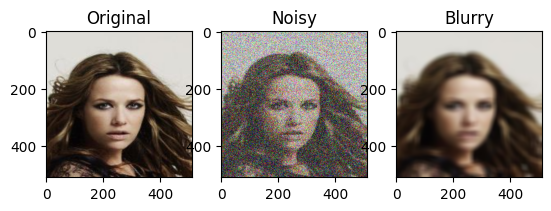

Sample 2:


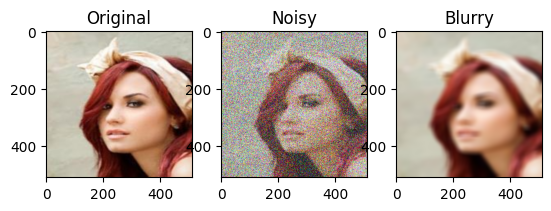

Sample 3:


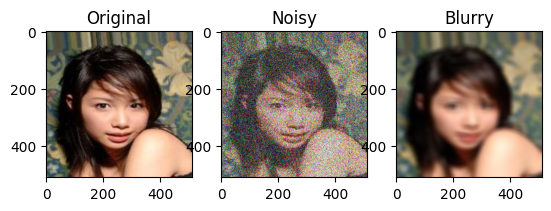

Sample 4:


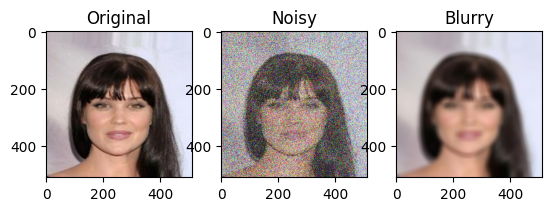

Sample 5:


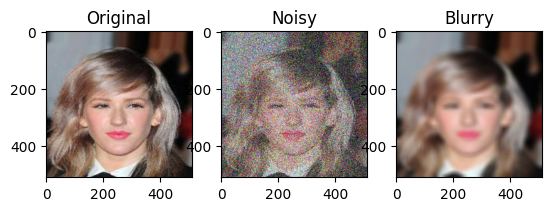

In [13]:
# Debugging script
def debug_dataloaders(original_loader, noisy_loader, blurry_loader, num_samples=5):
    original_iter = iter(original_loader)
    noisy_iter = iter(noisy_loader)
    blurry_iter = iter(blurry_loader)

    for i in range(num_samples):
        original_image, original_label = next(original_iter)
        noisy_image, noisy_label = next(noisy_iter)
        blurry_image, blurry_label = next(blurry_iter)

        print(f"Sample {i+1}:")
#         print("Original Label:", original_label)
#         print("Noisy Label:", noisy_label)

        # Optionally, visualize the images to compare
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(original_image[0].permute(1, 2, 0))
        plt.subplot(1, 3, 2)
        plt.title("Noisy")
        plt.imshow(noisy_image[0].permute(1, 2, 0))

        plt.subplot(1, 3, 3)
        plt.title("Blurry")
        plt.imshow(blurry_image[0].permute(1, 2, 0))

        plt.show()

# Debug dataloaders
debug_dataloaders(celeb_train_dataloader, celeb_noisy_train_dataloader, celeb_blurry_train_dataloader)


# **Convolutional AutoEncoder Architecture**

In [14]:
from torch import nn

---
# Convolutional Variational Autoencoder (v1) 
### 3 layers in encoder network
### 3 layers in decoder network
---

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE_v1(nn.Module):
    def __init__(self, img_channels=3, z_dim=256, img_size=64):
        super(CVAE_v1, self).__init__()
        self.img_size = img_size

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.enc_conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.enc_conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )

        # Determine the size of the output of the last convolutional layer
        conv_out_size = self.calculate_conv_output_size(img_size)

        self.enc_fc_mu = nn.Linear(128 * conv_out_size * conv_out_size, z_dim)
        self.enc_fc_logvar = nn.Linear(128 * conv_out_size * conv_out_size, z_dim)

        # Decoder layers
        self.dec_fc = nn.Linear(z_dim, 128 * conv_out_size * conv_out_size)
        self.dec_conv1 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_conv2 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_conv3 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=img_channels,
            kernel_size=4,
            stride=2,
            padding=1
        )

    def calculate_conv_output_size(self, img_size):
        # Calculate the output size after passing through the convolutional layers
        out_size = img_size
        for _ in range(3):  # 3 convolutional layers in encoder and decoder
            out_size = (out_size + 2 - 4) // 2 + 1  # Assuming kernel_size=4, stride=2, padding=1
        return out_size

    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = x.view(-1, 128 * self.calculate_conv_output_size(self.img_size) * self.calculate_conv_output_size(self.img_size))  # Flatten
        mu = self.enc_fc_mu(x)
        logvar = self.enc_fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decoder(self, z):
        x = self.dec_fc(z)
        x = x.view(-1, 128, self.calculate_conv_output_size(self.img_size), self.calculate_conv_output_size(self.img_size))  # Reshape
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = torch.sigmoid(self.dec_conv3(x))
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_image = self.decoder(z)
        return reconstructed_image, mu, logvar


In [16]:
from torchinfo import summary

model_CVAE_v1 = CVAE_v1(img_size=512)
model_CVAE_v1.name = 'model_CVAE_v1'
summary(model_CVAE_v1, input_size=[BATCH_SIZE, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
CVAE_v1                                  [16, 3, 512, 512]         --
├─Conv2d: 1-1                            [16, 32, 256, 256]        1,568
├─Conv2d: 1-2                            [16, 64, 128, 128]        32,832
├─Conv2d: 1-3                            [16, 128, 64, 64]         131,200
├─Linear: 1-4                            [16, 256]                 134,217,984
├─Linear: 1-5                            [16, 256]                 134,217,984
├─Linear: 1-6                            [16, 524288]              134,742,016
├─ConvTranspose2d: 1-7                   [16, 64, 128, 128]        131,136
├─ConvTranspose2d: 1-8                   [16, 32, 256, 256]        32,800
├─ConvTranspose2d: 1-9                   [16, 3, 512, 512]         1,539
Total params: 403,509,059
Trainable params: 403,509,059
Non-trainable params: 0
Total mult-adds (G): 100.52
Input size (MB): 50.33
Forward/backward pass size (MB): 1040.25
Pa

---
# # Convolutional Variational Autoencoder (v2) 
### 4 layers in encoder network
### 4 layers in decoder network
---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE_v2(nn.Module):
    def __init__(self, img_channels=3, z_dim=256, img_size=64):
        super(CVAE_v2, self).__init__()
        self.img_size = img_size

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(
                                   in_channels=img_channels, 
                                   out_channels=32, 
                                   kernel_size=4, 
                                   stride=2, 
                                   padding=1
                                  )
        
        self.enc_conv2 = nn.Conv2d(
                                    in_channels=32, 
                                    out_channels=64, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1
                                  )
        self.enc_conv3 = nn.Conv2d(
                                    in_channels=64, 
                                    out_channels=128, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1
                                  )
        self.enc_conv4 = nn.Conv2d(
                                    in_channels=128, 
                                    out_channels=256, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1
                                  )

        # Determine the size of the output of the last convolutional layer
        conv_out_size = self.calculate_conv_output_size(img_size)

        self.enc_fc_mu = nn.Linear(256 * conv_out_size * conv_out_size, z_dim)
        self.enc_fc_logvar = nn.Linear(256 * conv_out_size * conv_out_size, z_dim)

        # Decoder layers
        self.dec_fc = nn.Linear(z_dim, 256 * conv_out_size * conv_out_size)
        self.dec_conv1 = nn.ConvTranspose2d(
                                            in_channels=256, 
                                            out_channels=128, 
                                            kernel_size=4, 
                                            stride=2, 
                                            padding=1
                                           )
        self.dec_conv2 = nn.ConvTranspose2d(
                                            in_channels=128, 
                                            out_channels=64, 
                                            kernel_size=4, 
                                            stride=2, 
                                            padding=1
                                           )
        self.dec_conv3 = nn.ConvTranspose2d(
                                            in_channels=64, 
                                            out_channels=32, 
                                            kernel_size=4, 
                                            stride=2, 
                                            padding=1
                                           )
        self.dec_conv4 = nn.ConvTranspose2d(
                                            in_channels=32, 
                                            out_channels=img_channels, 
                                            kernel_size=4, 
                                            stride=2, 
                                            padding=1
                                           )

    def calculate_conv_output_size(self, img_size):
        # Calculate the output size after passing through the convolutional layers
        out_size = img_size
        for _ in range(4):  # 4 convolutional layers in encoder
            out_size = (out_size + 2 - 4) // 2 + 1  # Assuming kernel_size=4, stride=2, padding=1
        return out_size

    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_conv4(x))
        x = x.view(-1, 256 * self.calculate_conv_output_size(self.img_size) * self.calculate_conv_output_size(self.img_size))  # Flatten
        mu = self.enc_fc_mu(x)
        logvar = self.enc_fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decoder(self, z):
        x = self.dec_fc(z)
        x = x.view(-1, 256, self.calculate_conv_output_size(self.img_size), self.calculate_conv_output_size(self.img_size))  # Reshape
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = F.relu(self.dec_conv3(x))
        x = torch.sigmoid(self.dec_conv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_image = self.decoder(z)
        return reconstructed_image, mu, logvar


In [ ]:
from torchinfo import summary

model_CVAE_v2 = CVAE_v2(img_size=512)
summary(model_CVAE_v2, input_size=[BATCH_SIZE, 3, 512, 512])

---
# # Convolutional Variational Autoencoder (v3) 
### 5 layers in encoder network
### 5 layers in decoder network
---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE_v3(nn.Module):
    def __init__(self, img_channels=3, z_dim=256, img_size=64):
        super(CVAE_v3, self).__init__()
        self.img_size = img_size

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.enc_conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.enc_conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.enc_conv4 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.enc_conv5 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=4,
            stride=2,
            padding=1
        )

        # Determine the size of the output of the last convolutional layer
        conv_out_size = self.calculate_conv_output_size(img_size)

        self.enc_fc_mu = nn.Linear(512 * conv_out_size * conv_out_size, z_dim)
        self.enc_fc_logvar = nn.Linear(512 * conv_out_size * conv_out_size, z_dim)

        # Decoder layers
        self.dec_fc = nn.Linear(z_dim, 512 * conv_out_size * conv_out_size)
        self.dec_conv1 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_conv2 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_conv3 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_conv4 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_conv5 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=img_channels,
            kernel_size=4,
            stride=2,
            padding=1
        )

    def calculate_conv_output_size(self, img_size):
        # Calculate the output size after passing through the convolutional layers
        out_size = img_size
        for _ in range(5):  # 5 convolutional layers in encoder and decoder
            out_size = (out_size + 2 - 4) // 2 + 1  # Assuming kernel_size=4, stride=2, padding=1
        return out_size

    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_conv4(x))
        x = F.relu(self.enc_conv5(x))
        x = x.view(-1, 512 * self.calculate_conv_output_size(self.img_size) * self.calculate_conv_output_size(self.img_size))  # Flatten
        mu = self.enc_fc_mu(x)
        logvar = self.enc_fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decoder(self, z):
        x = self.dec_fc(z)
        x = x.view(-1, 512, self.calculate_conv_output_size(self.img_size), self.calculate_conv_output_size(self.img_size))  # Reshape
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = F.relu(self.dec_conv3(x))
        x = F.relu(self.dec_conv4(x))
        x = torch.sigmoid(self.dec_conv5(x))
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_image = self.decoder(z)
        return reconstructed_image, mu, logvar


In [ ]:
from torchinfo import summary

model_CVAE_v3 = CVAE_v3(img_size=512)
summary(model_CVAE_v3, input_size=[BATCH_SIZE, 3, 512, 512])

---
# Convolutional Variational Autoencoder (v4) 
### 4 layers in encoder network
### 4 layers in decoder network
### EXTRA : Added Batch normalization
---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE_norm(nn.Module):
    def __init__(self, img_channels=3, z_dim=256, img_size=64):
        super(CVAE_norm, self).__init__()
        self.img_size = img_size

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.enc_bn3 = nn.BatchNorm2d(128)
        self.enc_conv4 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.enc_bn4 = nn.BatchNorm2d(256)

        # Calculate the size of the output of the last convolutional layer
        conv_out_size = self.calculate_conv_output_size(img_size)

        self.enc_fc_mu = nn.Linear(256 * conv_out_size * conv_out_size, z_dim)
        self.enc_fc_logvar = nn.Linear(256 * conv_out_size * conv_out_size, z_dim)

        # Decoder layers
        self.dec_fc = nn.Linear(z_dim, 256 * conv_out_size * conv_out_size)
        self.dec_bn = nn.BatchNorm1d(256 * conv_out_size * conv_out_size)
        self.dec_conv1 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_bn1 = nn.BatchNorm2d(128)
        self.dec_conv2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_bn2 = nn.BatchNorm2d(64)
        self.dec_conv3 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.dec_bn3 = nn.BatchNorm2d(32)
        self.dec_conv4 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=img_channels,
            kernel_size=4,
            stride=2,
            padding=1
        )

    def calculate_conv_output_size(self, img_size):
        # Calculate the output size after passing through the convolutional layers
        out_size = img_size
        for _ in range(4):  # 4 convolutional layers in encoder
            out_size = (out_size + 2 - 4) // 2 + 1  # Assuming kernel_size=4, stride=2, padding=1
        return out_size

    def encoder(self, x):
        x = F.leaky_relu(self.enc_bn1(self.enc_conv1(x)))
        x = F.leaky_relu(self.enc_bn2(self.enc_conv2(x)))
        x = F.leaky_relu(self.enc_bn3(self.enc_conv3(x)))
        x = F.leaky_relu(self.enc_bn4(self.enc_conv4(x)))
        x = x.view(-1, 256 * self.calculate_conv_output_size(self.img_size) * self.calculate_conv_output_size(self.img_size))  # Flatten
        mu = self.enc_fc_mu(x)
        logvar = self.enc_fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decoder(self, z):
        x = self.dec_fc(z)
        x = self.dec_bn(x)
        x = x.view(-1, 256, self.calculate_conv_output_size(self.img_size), self.calculate_conv_output_size(self.img_size))  # Reshape
        x = F.leaky_relu(self.dec_bn1(self.dec_conv1(x)))
        x = F.leaky_relu(self.dec_bn2(self.dec_conv2(x)))
        x = F.leaky_relu(self.dec_bn3(self.dec_conv3(x)))
        x = torch.sigmoid(self.dec_conv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_image = self.decoder(z)
        return reconstructed_image, mu, logvar


In [ ]:
from torchinfo import summary

model_CVAE_norm = CVAE_norm(img_size=512)
summary(model_CVAE_norm, input_size=[16, 3, 512, 512])


In [35]:
def loss_function(recon_img, input_img, mu, logvar, beta=1.0):
#     print(f"input img size = {input_img.shape}")
#     print(f"reconstructed img size = {recon_img.shape}")
    input_img = input_img.view(recon_img.size())
#     print(f"after view input img size = {input_img.shape}")
    
    BCE = nn.functional.binary_cross_entropy(
        recon_img, input_img, reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + beta * KLD


In [36]:
# set random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [37]:
# from tqdm.auto import tqdm

# def train_func( model,
#                 epochs,
#                 train_dataloader,
#                 noisy_train_dataloader
#               ):
#     loss_history = []
#     num = 1
#     for epoch in tqdm(range(epochs)):
#         model.train()
#         total_loss = 0.0
#         for (clean_img, _), (noisy_img, _) in zip(train_dataloader, noisy_train_dataloader):
#             clean_img = clean_img.to(DEVICE)
#             noisy_img = noisy_img.to(DEVICE)
            
# #             print(f"image size : {noisy_img.shape}")
#             recon_img, mu, logvar = mode(noisy_img)
            
#             if num % 100 == 0:
#                 print(f"{num}, ", end="")
#             num += 1

#             # calculate the loss
#             loss = loss_function(recon_img=recon_img, input_img=clean_img, mu=mu, logvar=logvar)

#             optimizer.zero_grad()
#             loss.backward()
#             total_loss += loss.item()

#             optimizer.step()
#         num = 1
#         print()
#         average_loss = total_loss/len(train_dataloader.dataset)
#         loss_history.append(average_loss)
# #         if epoch % 10 == 0:
#         print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}')
        
# #         display_orig_noisy_clean_image(model, train_dataloader, noisy_train_dataloader)
# #     generate_loss_graph(epochs, loss_history)
#     return loss_history

# loss_history = train_func(model, 3, celeb_train_dataloader, celeb_noisy_train_dataloader)

In [38]:
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               clean_train_dataloader: torch.utils.data.DataLoader,
               noisy_train_dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer, 
               device: torch.device,
               loss_fn = loss_function
              ):
    loss_history = []
    train_loss = 0
    num = 1
    
    # 1. model 
    model.train()
    total_loss = 0.0
    for (clean_img, _), (noisy_img, _) in zip(clean_train_dataloader, noisy_train_dataloader):
        clean_img, noisy_img = clean_img.to(DEVICE), noisy_img.to(DEVICE)

        # 2. forward pass 
        recon_img, mu, logVar = model(noisy_img)

        if num % 100 == 0:
            print(f"{num}, ", end="")
        num += 1

        # 3. calculate the loss
        loss = loss_fn(recon_img=recon_img, 
                       input_img=clean_img, 
                       mu=mu, 
                       logvar=logVar)

        # 4. optimizer zero grad 
        optimizer.zero_grad()

        # 5. loss backward 
        loss.backward()
        
        ### accumulating the training loss
        train_loss += loss.item()

        # 6. optimizer step 
        optimizer.step()
        
        average_loss = total_loss / len(clean_train_dataloader.dataset)
    train_loss = train_loss / len(clean_train_dataloader.dataset)
    loss_history.append(average_loss)
    

    return train_loss

In [39]:
len(celeb_train_dataloader.dataset)

8000

In [40]:
def test_step(model: torch.nn.Module,
             clean_test_dataloader: torch.utils.data.DataLoader,
             noisy_test_dataloader: torch.utils.data.DataLoader,
             loss_fn,
             device: torch.device):
  ### TESTING
  test_loss = 0


  # Put the model into eval mode
  model.eval()

  # turn on inference mode
  with torch.inference_mode():
#     for X, y in data_loader:
    for (clean_test_img, _), (noisy_test_img, _) in zip(clean_test_dataloader, noisy_test_dataloader):
        # put the data X and y into  device
        clean_test_img, noisy_test_img = clean_test_img.to(device), noisy_test_img.to(device)

        # 1. forward pass (outputs raw logits )
        reconstructed_test_img, mu, logVar = model(noisy_test_img)

        # 2. calculate  the loss (accumulatively)
        loss = loss_fn(recon_img=reconstructed_test_img, input_img=clean_test_img, mu=mu, logvar=logVar)
#         loss = loss_fn(reconstructed_test_img, clean_test_img)
        test_loss += loss.item()

        # 3. calculate accuracy
#         test_pred_labels = test_pred_logits.argmax(dim=1)
#         test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)      # go from raw logits -> prediction labels

    # calculate the test loss and average per batc/h
    test_loss /= len(clean_test_dataloader.dataset)

    # calculate the test accuracy average per batch
#     test_acc /= len(data_loader)

  # print what's happening
  # print(f"\nTest loss: {train_loss:.4f}, Test accuracy: {test_acc:.4f}% \n")
    return test_loss

In [41]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          clean_train_dataloader: torch.utils.data.DataLoader,
          noisy_train_dataloader: torch.utils.data.DataLoader,
          clean_val_dataloader: torch.utils.data.DataLoader,
          noisy_val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler,
          loss_fn,
          epochs: int,
          device : torch.device = DEVICE):
    results = {"train_loss": [],
#             "train_acc": [],
            "test_loss": [],
#             "test_acc": []
              }

    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model = model,
                            clean_train_dataloader = clean_train_dataloader,
                            noisy_train_dataloader = noisy_train_dataloader,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            device = DEVICE
                           )
        if (epoch + 1) % 20 == 0 and epoch != 0:
            model_state_dict = model.state_dict()
            save_path = f"./models/{model.__class__.__name__}/model_{epoch}epoch_trained.pth"

            # Create the directory if it doesn't exist
            os.makedirs(os.path.dirname(save_path), exist_ok=True)

            # Save the model state dictionary to the specified path
            torch.save(model_state_dict, save_path)

      
        test_loss = test_step(model = model,
                              clean_test_dataloader = clean_val_dataloader,
                              noisy_test_dataloader = noisy_val_dataloader,
                              loss_fn = loss_fn,
                              device = DEVICE)

        # Update learning rate
        scheduler.step()

        # Save the model if the validation loss is improved
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            model_state_dict = model.state_dict()
            save_path = f"./models/{model.__class__.__name__}/best_model.pth"
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model_state_dict, save_path)

        print(f"Epoch: {epoch + 1} | Train loss : {train_loss:.4f} | Test Loss: {test_loss:.4f}")
        results["train_loss"].append(train_loss)
    #     results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
    #     results["test_acc"].append(test_acc)

        
        # Check if the current epoch has the same loss as the previous epoch
        if prev_loss is not None and train_loss == prev_loss:
            consecutive_same_loss_count += 1
        else:
            consecutive_same_loss_count = 0

        prev_loss = train_loss

        # If there are 4 consecutive epochs with the same loss, break out of the loop
        if consecutive_same_loss_count == 4:
            print("Training halted due to 4 consecutive epochs with the same loss.")
            break

    return results


In [48]:
def train_model(model, epochs, optimizer, state_dict_file=None):
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    if state_dict_file:
        print(f"{state_dict_file} present!!!")
        state_dict = torch.load(state_dict_file)
        # If the model was trained using DataParallel, you need to remove the 'module.' prefix
        # from all keys in the state_dict
        if next(iter(state_dict.keys())).startswith("module"):
            state_dict = {key[7:]: value for key, value in state_dict.items()}

            # Load the state_dict into the model
            model.load_state_dict(state_dict)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


    model_loss_results = train(model = model, 
                                clean_train_dataloader = celeb_train_dataloader, 
                                noisy_train_dataloader = celeb_noisy_train_dataloader, 
                                clean_val_dataloader = celeb_val_dataloader, 
                                noisy_val_dataloader = celeb_noisy_val_dataloader,
                                optimizer = optimizer,
                                scheduler = scheduler,
                                loss_fn = loss_function, 
                                epochs = epochs, 
                                device = DEVICE
                               )
    return model_loss_results

In [2]:
model_CVAE_v1 = CVAE_v1(img_size=IMAGE_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model_CVAE_v1.parameters(), lr=LR)          # lr = alpha {learning rate}

# def train_model(model, epochs, optimizer, state_dict_file=None):
model_CVAE_v1_result = train_model(model=model_CVAE_v1, 
                                   epochs=8, 
                                   optimizer=optimizer, 
                                   state_dict_file="./models/CVAE_v1/model_6epoch_trained.pth"
                                  )

./models/CVAE_v1/model_6epoch_trained.pth present!!!


  0%|          | 0/8 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 332.12 MiB is free. Process 7039 has 15.57 GiB memory in use. Of the allocated memory 14.69 GiB is allocated by PyTorch, and 579.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [29]:
model_CVAE_va1_loss

{'train_loss': [434726.9015625,
  406450.866,
  399816.812375,
  396461.144625,
  394198.4356875,
  392477.69475,
  391343.253125,
  390188.8188125],
 'train_acc': [],
 'test_loss': [410705.423,
  404899.68025,
  397715.77375,
  395835.944,
  394416.867,
  393500.72775,
  393011.4355,
  392359.4105],
 'test_acc': []}

In [1]:
model_CVAE_va1_loss

{'train_loss': [434726.9015625,
  406450.866,
  399816.812375,
  396461.144625,
  394198.4356875,
  392477.69475,
  391343.253125,
  390188.8188125],
 'train_acc': [],
 'test_loss': [410705.423,
  404899.68025,
  397715.77375,
  395835.944,
  394416.867,
  393500.72775,
  393011.4355,
  392359.4105],
 'test_acc': []}

In [ ]:
loss_history

# **Saving model**

In [ ]:
model_state_dict = model_3.state_dict()
#### this is not parallel model hait ta
save_path = './models/parallel_model_3_200epoch_trained.pth'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model state dictionary to the specified path
torch.save(model_state_dict, save_path)


In [ ]:
loss_history = train_func(model_3, 200, celeb_train_dataloader, celeb_noisy_train_dataloader)

model_state_dict = model_3.state_dict()
#### this is not parallel model as well hait ta
save_path = './models/parallel_model_3_400epoch_trained.pth'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model state dictionary to the specified path
torch.save(model_state_dict, save_path)


# **generating loss graph**

In [ ]:
def generate_loss_graph(epochs, loss_history,):
        # Plotting the loss graph
    plt.figure(figsize=(25,25))
    plt.plot(range(1, 26), loss_history[:25], marker='o', linestyle='-', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()

# generate_loss_graph(2, )
    

In [ ]:
!ls -al ./models -h

In [ ]:
index = 300

original_image = celeb_val_dataloader.dataset[index][0]

nosiy_image = celeb_noisy_val_dataloader.dataset[index][0]
model.eval()
with torch.inference_mode():
    reconstructed_image, _, _ = model(nosiy_image.unsqueeze(0).to(DEVICE))


plt.subplot(1, 3, 1)
plt.imshow(original_image.permute(1,2,0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(nosiy_image.permute(1,2,0))
plt.title('Nosiy Image')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image.squeeze().cpu().permute(1,2,0))
plt.title('Reconstructed')
plt.axis('off')


plt.show()


In [ ]:
!mkdir data

In [ ]:
import torchvision.transforms.functional as TF


import requests 
from pathlib import Path
image_path =Path("./data/asd.png")

# download image if it does not exits
if not image_path.is_file():
    with open(image_path, "wb") as f:
        request = requests.get("https://files.saurabtharu.com.np/nihang.jpg")
        print(f"Downloading {image_path}")
        f.write(request.content)
        
else:
    print(f"{image_path} already exists, skipping download...")
    
    
import torchvision
image = torchvision.io.read_image(str(image_path))

image_1 = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.

image_1 = add_noise_to_image(image_1,0.6)


plt.imshow(image_1.permute(1,2,0))

image_pil = TF.to_pil_image(image_1)

transformed_image = transform(image_pil)

model.eval()
with torch.inference_mode():
    denoised, _, _ = model(transformed_image.unsqueeze(0).to(DEVICE))

plt.subplot(1,2,1)
plt.title("noisy input image to model")
plt.imshow(transformed_image.squeeze(0).cpu().permute(1,2,0))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("denoised image")
plt.imshow(denoised.squeeze(0).cpu().permute(1,2,0))
plt.axis('off')
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt

def test_model(
                    state_dict_file,
                celeb_val_dataloader = celeb_val_dataloader,
                celeb_noisy_val_dataloader = celeb_noisy_val_dataloader
              ):
    # Initialize your model architecture
    model = CVAE(img_size=IMAGE_SIZE).to(DEVICE)

    # Load the state_dict
    state_dict = torch.load(state_dict_file)
    print(type(state_dict))

    # If the model was trained using DataParallel, you need to remove the 'module.' prefix
    # from all keys in the state_dict
    if next(iter(state_dict.keys())).startswith("module"):
        state_dict = {key[7:]: value for key, value in state_dict.items()}

    # Load the state_dict into the model
    model.load_state_dict(state_dict)
#     print(f"type of model : {type(model)}")
    

    index = 20

    original_image = celeb_val_dataloader.dataset[index][0]

    nosiy_image = celeb_noisy_val_dataloader.dataset[index][0]
    model.eval()
    with torch.inference_mode():
        reconstructed_image, _, _ = model(nosiy_image.unsqueeze(0).to(DEVICE))


    plt.subplot(1, 3, 1)
    plt.imshow(original_image.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(nosiy_image.permute(1, 2, 0))
    plt.title("Nosiy Image")
    plt.axis("off")


    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_image.squeeze().cpu().permute(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()
    
test_model("./models/parallel_model_50epoch_trained.pth", celeb_val_dataloader, celeb_noisy_val_dataloader)
# test_model(celeb_val_dataloader, celeb_noisy_val_dataloader, './models/parallel_model_3_200epoch_trained.pth')
# test_model(celeb_val_dataloader, celeb_noisy_val_dataloader, "./models/parallel_model_3_400epoch_trained.pth")

In [ ]:
# Initialize your model architecture
model = CVAE(img_size=IMAGE_SIZE).to(DEVICE)

# Load the state_dict
state_dict = torch.load("./models/parallel_model_50epoch_trained.pth")
print(type(state_dict))

# If the model was trained using DataParallel, you need to remove the 'module.' prefix
# from all keys in the state_dict
if next(iter(state_dict.keys())).startswith("module"):
    state_dict = {key[7:]: value for key, value in T.items()}

# Load the state_dict into the model
model.load_state_dict(state_dict)


train_func(model, 50, celeb_train_dataloader, celeb_noisy_train_dataloader)

In [ ]:
test_model("./models/parallel_model_50epoch_trained.pth", celeb_val_dataloader, celeb_noisy_val_dataloader)
